# Mini Project BGP 3
# Assignment 2 Regression

William Arthurius & Annisa Rizqilana
October 2024

# Intializing

In [1]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

In [2]:
try:
    # Initialize the library.
    ee.Initialize()
    print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
    print('Google Earth Engine has failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

Google Earth Engine has initialized successfully!


# Getting Data

In [3]:
import geemap
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [4]:
#fc = ee.FeatureCollection(Map.draw_last_feature)
#region = fc.geometry([[[36.644321, -1.490252],
#  [36.644321, -1.153886],
#  [37.109971, -1.153886],
#  [37.109971, -1.490252],
#  [36.644321, -1.490252]]])
#cords = region.getInfo()['coordinates']
#cords

In [5]:
# # or alternatively use the following predefined rectangle
region = ee.Geometry.Polygon(
[[[36.644321, -1.490252],
  [36.644321, -1.153886],
  [37.109971, -1.153886],
  [37.109971, -1.490252],
  [36.644321, -1.490252]]]
 )

In [6]:
myCollection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(region) \
    .filterDate('2020-01-01', '2020-12-31') \
    .filterMetadata('CLOUD_COVER', 'less_than', 10)

In [7]:
# List the cloud cover percentage for each image in the collection
cloud_info = myCollection.aggregate_array('CLOUD_COVER').getInfo()
image_ids = myCollection.aggregate_array('system:index').getInfo()

# Print the cloud cover for each image
for img_id, cloud_cover in zip(image_ids, cloud_info):
    print(f"Image ID: {img_id}, Cloud Cover: {cloud_cover}%")

Image ID: LC08_168061_20200220, Cloud Cover: 1.32%
Image ID: LC08_168061_20200830, Cloud Cover: 3.27%


In [8]:
listOfImages = myCollection.aggregate_array('system:index').getInfo()
print('Number of images in the collection: ', len(listOfImages))
listOfImages

Number of images in the collection:  2


['LC08_168061_20200220', 'LC08_168061_20200830']

In [9]:
# Visualize the first Landsat Map

img1 = myCollection.first().clip(region)
vis_params = {"min": 0, 
              "max": 15000, 
              "bands": ["SR_B4", "SR_B3", "SR_B2"]}  
Map2 = geemap.Map()
Map2.addLayer(img1, vis_params, "FirstImage", True) 
Map2

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

# NDVI

In [10]:
# Function to calculate NDVI on a monthly composite
def calculate_ndvi_for_month(year, month):
    # Define start and end dates for the month
    start_date = ee.Date(f"{year}-{month:02d}-01")
    end_date = start_date.advance(1, 'month')
    
    # Filter images within the date range and calculate the median composite
    monthly_composite = myCollection.filterDate(start_date, end_date).median()
    
    # Calculate NDVI from the median composite
    ndvi = monthly_composite.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return ndvi.set('month', f"{year}-{month:02d}")

# Calculate NDVI for February and August 2020
# The data is only avalaible for February & August 2020, I cant use the other month due to high cloud cover
ndvi_february = calculate_ndvi_for_month(2020, 2)
ndvi_august = calculate_ndvi_for_month(2020, 8)

In [11]:
# Visualization parameters for NDVI
vis_params_ndvi = {
    'min': -0.1,
    'max': 0.6,
    'palette': ['blue', 'white', 'green']
}

# Add February and August NDVI layers to the map
Map.addLayer(ndvi_february.clip(region), vis_params_ndvi, "NDVI February 2020")
Map.addLayer(ndvi_august.clip(region), vis_params_ndvi, "NDVI August 2020")

# Display the map
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

# Elevation

In [12]:
# Load the SRTM elevation data
srtm_elevation = ee.Image("USGS/SRTMGL1_003").select("elevation").clip(region)

# Display elevation on the map (optional)
elevation_vis_params = {
    "min": 0,
    "max": 3000,
    "palette": ["blue", "green", "yellow", "brown", "white"]
}
Map.addLayer(srtm_elevation, elevation_vis_params, "Elevation (SRTM)", True)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

# Precipitation

In [13]:
# Function to calculate monthly precipitation by summing daily values
def calculate_monthly_precipitation(year, month):
    start_date = ee.Date(f"{year}-{month:02d}-01")
    end_date = start_date.advance(1, 'month')
    
    # Sum daily precipitation within the month
    precipitation = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
        .filterDate(start_date, end_date) \
        .sum() \
        .rename("precipitation")
    
    return precipitation.set('month', f"{year}-{month:02d}")

# Calculate precipitation for February and August 2020, as same as NDVI data
precipitation_february = calculate_monthly_precipitation(2020, 2)
precipitation_august = calculate_monthly_precipitation(2020, 8)

In [14]:
# Visualization parameters for precipitation
vis_params_precip = {
    'min': 0,
    'max': 300,
    'palette': ['lightblue', 'blue', 'darkblue']
}

# Visualize February and August precipitation on the map
Map.addLayer(precipitation_february.clip(region), vis_params_precip, "Precipitation February 2020")
Map.addLayer(precipitation_august.clip(region), vis_params_precip, "Precipitation August 2020")

# Display the map with precipitation layers
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

# Data Sampling 

In [15]:
# Generate 1000 random points within the region
random_points = ee.FeatureCollection.randomPoints(region, 1000, seed=42)

# Display the random points on the map
Map.addLayer(random_points, {}, "Random Points")
Map.centerObject(region)

Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [16]:
# Create combined image with all predictor and target bands
combined_image = (
    ndvi_february.rename("NDVI_February")
    .addBands(ndvi_august.rename("NDVI_August"))
    .addBands(srtm_elevation.rename("Elevation"))
    .addBands(precipitation_february.rename("Precipitation_February"))
    .addBands(precipitation_august.rename("Precipitation_August"))
)

In [17]:
# Sample the combined data for all bands
sampled_data = combined_image.sampleRegions(
    collection=random_points,
    scale=30,
    geometries=True
)

In [18]:
# Export the sampled data to CSV using geemap
output_csv = './sampled_data.csv'
geemap.ee_export_vector(sampled_data, filename=output_csv)

print(f"Sampled data exported to {output_csv}")

Generating URL ...
Please wait ...
Data downloaded to /data/private/BGP/sampled_data.csv
Sampled data exported to ./sampled_data.csv


# Data Cleaning

In [19]:
import pandas as pd

# Load the CSV file
data = pd.read_csv('sampled_data.csv')

In [20]:
data.head()

,Precipitation_February,Elevation,NDVI_August,Precipitation_August,NDVI_February,system:index
0,72.970635,1888,0.226761,16.290746,0.359078,0_0
1,51.921231,1614,0.151698,6.716886,0.195440,1_0
2,62.431686,1741,0.187869,16.729264,0.266376,2_0
3,70.412409,1677,0.237223,12.633935,0.331406,3_0
4,80.160094,1594,0.082195,10.396948,0.125478,4_0


In [21]:
# Rename the column for clarity
data = data.rename(columns={
    "system:index": "ID",
    "NDVI_February": "NDVI_February",
    "Precipitation_February": "Precipitation_February",
    "Elevation": "Elevation",
    "NDVI_August": "NDVI_August",
    "Precipitation_August": "Precipitation_August"
})

# Ensure the data is in wide format, with each ID having columns for February and August values side-by-side
data_wide = data[[
    "ID", 
    "Elevation", 
    "NDVI_February", "Precipitation_February", 
    "NDVI_August", "Precipitation_August"
]]

# Display the reshaped data
print(data_wide.head())

    ID  Elevation  NDVI_February  Precipitation_February  NDVI_August  \
0  0_0       1888       0.359078               72.970635     0.226761   
1  1_0       1614       0.195440               51.921231     0.151698   
2  2_0       1741       0.266376               62.431686     0.187869   
3  3_0       1677       0.331406               70.412409     0.237223   
4  4_0       1594       0.125478               80.160094     0.082195   

   Precipitation_August  
0             16.290746  
1              6.716886  
2             16.729264  
3             12.633935  
4             10.396948  


In [22]:
# Reshape the data from wide to long format
data_long = pd.melt(data_wide, 
                    id_vars=["ID", "Elevation"], 
                    value_vars=["NDVI_February", "NDVI_August", "Precipitation_February", "Precipitation_August"],
                    var_name="Variable", 
                    value_name="Value")

# Extract the month and variable name from the "Variable" column
data_long['Month'] = data_long['Variable'].str.extract(r'_(February|August)')[0]
data_long['Variable'] = data_long['Variable'].str.replace(r'_(February|August)', '', regex=True)

# Pivot the data to have separate columns for NDVI and Precipitation
data_long = data_long.pivot_table(index=["ID", "Elevation", "Month"], columns="Variable", values="Value").reset_index()

# Display the transformed data to verify
print(data_long.head())

Variable     ID  Elevation     Month      NDVI  Precipitation
0           0_0       1888    August  0.226761      16.290746
1           0_0       1888  February  0.359078      72.970635
2         100_0       1555    August  0.130315       5.156040
3         100_0       1555  February  0.250845      50.103367
4         101_0       1608    August  0.160356       9.876567


# Machine Learning Regression

In [23]:
# Select features (predictors) and target
X = data_long[['Elevation', 'Precipitation']]
y = data_long['NDVI']

In [24]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Regression: MLP Regressor

In [26]:
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor()

In [27]:
%%time
# training phase
reg.fit(X_train, y_train)

# classification (prediction) phase
y_hat_mlp = reg.predict(X_test)

CPU times: user 3.62 s, sys: 5.14 s, total: 8.76 s
Wall time: 234 ms


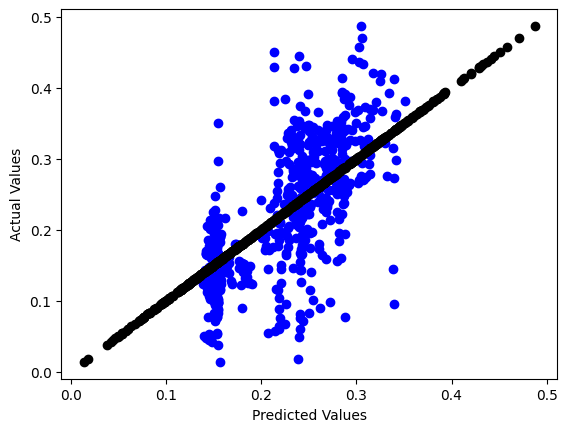

In [28]:
import matplotlib.pyplot as plt
plt.scatter(y_hat_mlp, y_test,c='b')
plt.scatter(y_test, y_test,c='k')
#plt.title('Scatter plot')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics
mae = mean_absolute_error(y_test, y_hat_mlp)
mse = mean_squared_error(y_test, y_hat_mlp)
r2 = r2_score(y_test, y_hat_mlp)

# Display the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 0.049418017531613415
Mean Squared Error (MSE): 0.004365100424783252
R-squared (R²): 0.4949313889827792


# Regression: Random Forest

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_hat_rf = rf.predict(X_test)

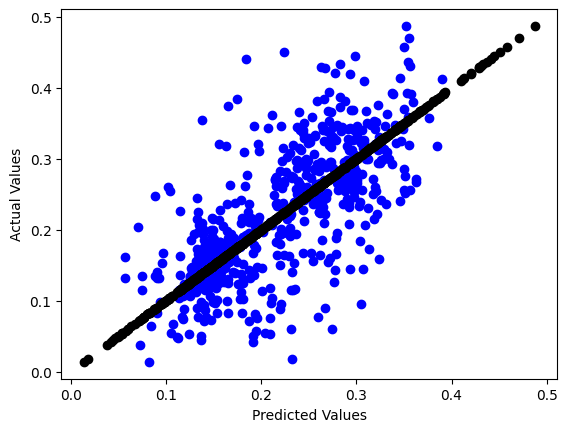

In [31]:
import matplotlib.pyplot as plt
plt.scatter(y_hat_rf, y_test,c='b')
plt.scatter(y_test, y_test,c='k')
#plt.title('Scatter plot')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics
mae_rf = mean_absolute_error(y_test, y_hat_rf)
mse_rf = mean_squared_error(y_test, y_hat_rf)
r2_rf = r2_score(y_test, y_hat_rf)

# Display the results
print("Random Forest Regressor Model Accuracy Metrics:")
print("Mean Absolute Error (MAE):", mae_rf)
print("Mean Squared Error (MSE):", mse_rf)
print("R-squared (R²):", r2_rf)

Random Forest Regressor Model Accuracy Metrics:
Mean Absolute Error (MAE): 0.04818196831091162
Mean Squared Error (MSE): 0.004299796250416642
R-squared (R²): 0.5024874782891571


# Hyperparameter Optimization

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from time import time

# Define parameter distributions for RandomizedSearchCV
param_dist = {
    "n_estimators": sp_randint(100, 300),     
    "max_depth": [None, 10, 20, 30],
    "max_features": sp_randint(1, 3),          # Only values 1 or 2, because you have 2 features
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(1, 5),
    "bootstrap": [True, False],
    "criterion": ["squared_error", "absolute_error"]
}

# Number of parameter settings to sample
n_iter_search = 20

# Run RandomizedSearchCV with RandomForestRegressor
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   n_iter=n_iter_search, cv=5)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings." % 
      ((time() - start), n_iter_search))

# Output the best parameters found
best_params = random_search.best_params_
print("Best parameters found:", best_params)

RandomizedSearchCV took 120.80 seconds for 20 candidates parameter settings.
Best parameters found: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 20, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 240}


In [34]:
# Get the best model from random search
best_random = random_search.best_estimator_

# Fit the best model on the training data
best_random.fit(X_train, y_train)

# Predict on the test data
y_hat_rf = best_random.predict(X_test)

# Calculate metrics
mae_rf = mean_absolute_error(y_test, y_hat_rf)
mse_rf = mean_squared_error(y_test, y_hat_rf)
r2_rf = r2_score(y_test, y_hat_rf)

# Display the results
print("Random Forest Regressor Model Accuracy Metrics:")
print("Mean Absolute Error (MAE):", mae_rf)
print("Mean Squared Error (MSE):", mse_rf)
print("R-squared (R²):", r2_rf)

Random Forest Regressor Model Accuracy Metrics:
Mean Absolute Error (MAE): 0.04423724808577431
Mean Squared Error (MSE): 0.0035716040713094253
R-squared (R²): 0.586743732822762


In [38]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for GridSearchCV
param_grid = {
    "n_estimators": [100, 133, 150, 200],      # Try specific values for n_estimators
    "max_depth": [10, 20, 30, None],
    "max_features": [1, 2],                    # Since you have only 2 features
    "min_samples_split": [2, 5, 9, 10],
    "min_samples_leaf": [1, 2, 3, 4],
    "bootstrap": [True, False],
    "criterion": ["squared_error", "absolute_error"]
}

# Instantiate GridSearchCV with the RandomForestRegressor
grid_search = GridSearchCV(estimator=RandomForestRegressor(), 
                           param_grid=param_grid, 
                           cv=5,               # Number of cross-validation folds
                           verbose=0,          # Show progress
                           n_jobs=-1)          # Use all available cores

# Run the grid search
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_grid = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

Best parameters found: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}


In [39]:
# Get the best model from random search
best_random = random_search.best_estimator_

# Fit the best model on the training data
best_random.fit(X_train, y_train)

# Predict on the test data
y_hat_rf = best_random.predict(X_test)

# Calculate metrics
mae_rf = mean_absolute_error(y_test, y_hat_rf)
mse_rf = mean_squared_error(y_test, y_hat_rf)
r2_rf = r2_score(y_test, y_hat_rf)

# Display the results
print("Random Forest Regressor Model Accuracy Metrics:")
print("Mean Absolute Error (MAE):", mae_rf)
print("Mean Squared Error (MSE):", mse_rf)
print("R-squared (R²):", r2_rf)

Random Forest Regressor Model Accuracy Metrics:
Mean Absolute Error (MAE): 0.04417273047461111
Mean Squared Error (MSE): 0.0035492323258318457
R-squared (R²): 0.5893322795490274
